Before we begin, let's enable Google Colab's free GPU to speed up the training process. Click on **Edit**, **Notebook Settings**, and then select **GPU** as the hardware accelator. To import the project data, run the cell below by pressing **Shift + Enter**. Click **Choose Files** to upload the train_posters.zip and test_posters.zip from your local machine using **files.upload( )**. This will take 5-10 minutes.

In the meantime, upload the train_data.csv and test_data.csv by clicking on the black arrow tab on the left side of the screen and then the Files tab. Click on Upload and upload the train_data.csv and test_data.csv. The training .csv file contains tabular data as well as the necessary labels for our training images while the test .csv file includes tabular data only. 









In [0]:
from google.colab import files
files.upload()

{}

Use the **unzip** command to unzip the folders containing the training and test images.

In [0]:
!unzip train_posters.zip
!unzip test_posters.zip

Archive:  train_posters.zip
   creating: train_posters/
  inflating: train_posters/100114.jpg  
  inflating: train_posters/100150.jpg  
  inflating: train_posters/100157.jpg  
  inflating: train_posters/100232.jpg  
  inflating: train_posters/1002535.jpg  
  inflating: train_posters/1002540.jpg  
  inflating: train_posters/1002543.jpg  
  inflating: train_posters/1002963.jpg  
  inflating: train_posters/100332.jpg  
  inflating: train_posters/100405.jpg  
  inflating: train_posters/100442.jpg  
  inflating: train_posters/100624.jpg  
  inflating: train_posters/1007028.jpg  
  inflating: train_posters/1007032.jpg  
  inflating: train_posters/100758.jpg  
  inflating: train_posters/1008010.jpg  
  inflating: train_posters/100822.jpg  
  inflating: train_posters/100828.jpg  
  inflating: train_posters/100931.jpg  
  inflating: train_posters/1010005.jpg  
  inflating: train_posters/1010055.jpg  
  inflating: train_posters/1010248.jpg  
  inflating: train_posters/1010265.jpg  
  inflating: 

Import necessary Python libraries and read the train_data csv file using Pandas. We sort the rows of the data with respect to the IMDB ID numbers to match the order of the training images. To get the genre labels, we simply grab the last column of the** csv_data** array and assign it to the **genres** variable. 

Since this is a classification task, let's one-hot encode our labels (0,1,2,3). For example, a label of 0 will be one-hot encoded into the vector [1 0 0 0] and a label of 1 will be one-hot encoded into the vector [0 1 0 0]. We use the ** to_categorical** function from Keras, a high-level deep learning Python library that runs on top of Tensorflow, to one-hot encode our labels. 

Throughout this notebook, I would highly suggest printing out variables to get an understand of what they look like as well as to encourage good debugging practices. 

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import os
import cv2
import matplotlib.pyplot as plt

# Read csv data
# Reorder the labels to match the order of the images

csv_data = pd.read_csv('train_data.csv').as_matrix()

csv_data = csv_data[csv_data[:,1].argsort()]
genres = csv_data[:,-1]
scores = csv_data[:,5]
runtime = csv_data[:,4]

test_data_csv = pd.read_csv('test_data.csv').as_matrix()

# One-hot encode genres column

train_labels = to_categorical(np.array(genres))
print("Label for first training example: {}".format(genres[0]))
print("One-hot encoded label for first training example: {}".format(train_labels[0]))


Using TensorFlow backend.


Label for first training example: 3
One-hot encoded label for first training example: [0. 0. 0. 1.]


We create variables storing the paths to our training and test image directories. Inside the **preprocess_training_data** function, we sort the images with respect to the IMDB IDs. We then create an empty list called **train_images**, preprocess each image, and append the new image into our **train_images** list. 

Using cv2, we read the image as a grayscale image and resize the image into a 64x64 image. We normalize the image by dividing by 255 since each pixel has a value between 0 and 255 to speed up convergence during the training process. We reshape the output in a way that the Convolutional Neural Network can work with the data. 

Repeat the process for the test images. 

In [0]:
train_data = 'train_posters'
test_data = 'test_posters'


face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') #need to have the xml file in the files directory! #used to find faces

def preprocess_training_data():
    train_images = []
    train_edges = []
    num_faces = []
    

    for ind,i in enumerate(csv_data[:,1]):

        path = os.path.join(train_data,str(i) + ".jpg")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        #finds the number of faces in a poster
        num_faces.append(len(face_cascade.detectMultiScale(img, 1.3, 5)))
        
        img = cv2.resize(img, (64,64))
        
        train_images.append(np.array(img)/255)
        #print(img)
       
        kernel = np.ones((3,3),np.float32)/9 
        img_smoothed = cv2.filter2D(img,-1,kernel) #smoothing the image with an averaging kernel
        
        
        #train_edges.append(np.array(cv2.Laplacian(img,cv2.CV_64F)/255)) #2 options for edge detection, comment out one of the lines
        
        
        train_edges.append(np.array(cv2.Canny(img_smoothed,100,250)/255)) #2 options for edge detection, comment out one of the lines
    return train_images, train_edges, num_faces


def preprocess_test_data():
    test_images = []
    for ind,i in enumerate(test_data_csv[:,1]):

        path = os.path.join(test_data,str(i) + ".jpg")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64,64))
        test_images.append(np.array(img)/255)
            
    return test_images
    
preprocessed_train,train_edges, num_faces = preprocess_training_data()
preprocessed_test = preprocess_test_data()
#print(train_edges)
print(num_faces)
x_train = np.array(preprocessed_train).reshape(-1,64,64,1)
x_train_edges = np.array(train_edges).reshape(-1,64,64,1)
#print(train_edges[0])
#print('sep')
#print(x_train_edges[0])
y_train = train_labels

x_test = np.array(preprocessed_test).reshape(-1,64,64,1)
print('done')

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 0, 3, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 1, 3, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0, 0, 2, 1, 0, 

Try displaying the movie posters from both the training and test images. Since **x_train** and **x_test** are reshaped in a CNN usable format, we aren't able to visualize it easily. Instead use the **preprocessed_train** and ** preprocessed_test** lists. Print out the associated label and movie title of the training image to verify the order is correct. 

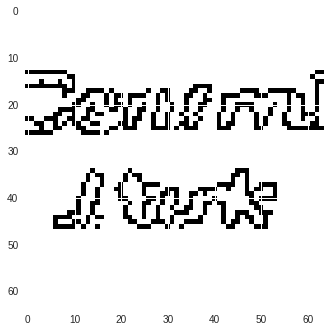

In [0]:
# Display training example #1371 Death Note, a well-acclaimed Hollywood adaption of the Death Note anime (jk)
# Display movie poster and associated label and title

# Feel free to change the train_ind and see how the preprocessing affect the images
train_ind = 0
plt.imshow(preprocessed_train[train_ind])
plt.imshow(train_edges[train_ind])
#print(train_edges[train_ind])
#print(preprocessed_train[train_ind])


In [0]:
# Displaying test example #200 
# Remember there is no genre label or title associated with this image
# We are trying to predict the labels! 

plt.imshow(preprocessed_test[200])
print("Test example #200")

After preprocessing the images, we can now create our CNN by specifying the network architecture using Keras, a library that makes it easy to create deep neural networks. 

I will not explain what each layer does as you can simply read the Keras documentation and/or Google how a CNN works. 

I left the ** activation** function argument blank to encourage you guys to research activation functions and try out different ones. In your write-up, please explain why you chose a specific activation function or a combination of activation functions!

I also left the** epochs** and **batch_size** arguments blank as well. Try experimenting with different number of epochs and batch sizes! 

When running this cell, you should see a training progress bar at the bottom for every epoch as well as the associated loss and training accuracy. Remember, just because you get a very high training accuracy does not necessarily mean you will get a similar accuracy for the test data. Why is that? 

In [0]:
from keras import Sequential
from keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential()

model.add(InputLayer(input_shape=[64,64,1]))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),padding='same'))

model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x=x_train_edges, y=y_train, epochs=10, batch_size=20)
model.summary()

Epoch 1/10
3094/3094 [==============================] - 3s 1ms/step - loss: 2.3401 - acc: 0.3242
Epoch 2/10
3094/3094 [==============================] - 2s 636us/step - loss: 1.3688 - acc: 0.3297
Epoch 3/10
3094/3094 [==============================] - 2s 636us/step - loss: 1.3662 - acc: 0.3245
Epoch 4/10
3094/3094 [==============================] - 2s 628us/step - loss: 1.3078 - acc: 0.3730
Epoch 5/10
3094/3094 [==============================] - 2s 632us/step - loss: 1.0015 - acc: 0.6080
Epoch 6/10
3094/3094 [==============================] - 2s 636us/step - loss: 0.4049 - acc: 0.8988
Epoch 7/10
3094/3094 [==============================] - 2s 633us/step - loss: 0.0816 - acc: 0.9955
Epoch 8/10
3094/3094 [==============================] - 2s 636us/step - loss: 0.0204 - acc: 0.9994
Epoch 9/10
3094/3094 [==============================] - 2s 646us/step - loss: 0.0094 - acc: 0.9997
Epoch 10/10
3094/3094 [==============================] - 2s 638us/step - loss: 0.0061 - acc: 0.9997
___________

The next step is to create a vector of predictions by sending your test images through the trained CNN. **Figure out a way to output predicted labels using your test data and then converting it into a proper .csv file that Kaggle can use. **

This project is a great introduction into deep learning and so I encourage you guys to be curious and have fun! 

Here are some suggestions to improve this network:
1. Add more layers
2. Figure out a way to prevent overfitting on the training data
3. Experiment with different hyperparameters like activation function, optimizers, batch sizes, etc. 
4. Preprocessing methods
5. Figure out a way to utilize the tabular data from the train_data.csv file 

In [0]:
#code for returning predictions based on the trained model
y_test_pred = model.predict(x=x_test,batch_size=None, verbose=0, steps=None)
y_test_adjusted = []
for prediction in y_test_pred: #finding the category with the highest probablity and choosing that as the guess
  max_value = max(prediction)
  max_index = np.where(prediction == max_value)
  y_test_adjusted.append(max_index[0][0])
  
#print(y_test_adjusted)
#print(len(y_test_adjusted))

#turns the vector of predicted categories into the proper csv format
import csv

csvfile = "prediction.csv"
ID = 0;
#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(['ID','Category'])
    for val in y_test_adjusted:
        writer.writerow([ID,val])
        ID += 1

In [0]:
#dividing training data into our own training and test for our own testing purposes
from keras import Sequential
from keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, SpatialDropout2D, Dropout

k = 2500
our_train_images = x_train[0:k]
our_test_images = x_train[k:-1]

our_train_edges = x_train_edges[0:k]
our_test_edges = x_train_edges[k:-1]


our_train_labels = y_train[0:k]
our_test_labels = y_train[k:-1]


our_model = Sequential()

our_model.add(InputLayer(input_shape=[64,64,1]))
our_model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
our_model.add(MaxPool2D(pool_size=(2,2),padding='same'))

our_model.add(Flatten())
our_model.add(Dense(32, activation='tanh'))
our_model.add(Dropout(0.1))
our_model.add(Dense(32, activation='tanh'))
our_model.add(Dense(4, activation='softmax'))

our_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

our_model.fit(x=our_train_edges, y=our_train_labels, epochs=10, batch_size=5)
our_model.summary()
our_y_test_pred = our_model.predict(x=our_test_edges,batch_size=None, verbose=0, steps=None)
our_y_test_adjusted = []
for prediction in our_y_test_pred: #finding the category with the highest probablity and choosing that as the guess
  max_value = max(prediction)
  max_index = np.where(prediction == max_value)
  our_y_test_adjusted.append(max_index[0][0])

  
#evalutating the model on the last 93 posters

match = [i for i, j in zip(our_y_test_adjusted, np.nonzero(our_test_labels)[1]) if i == j]
print(len(match)/len(our_y_test_adjusted)*100)

Epoch 1/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.4102 - acc: 0.2844
Epoch 2/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3941 - acc: 0.2688
Epoch 3/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3824 - acc: 0.2992
Epoch 4/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3822 - acc: 0.2916
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3735 - acc: 0.3048
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3076 - acc: 0.3772
Epoch 7/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.0104 - acc: 0.5932
Epoch 8/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.5758 - acc: 0.7996
Epoch 9/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2566 - acc: 0.9216
Epoch 10/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1128 - acc: 0.9708
_____________________________